In [195]:
import numpy as np
from matplotlib import pyplot as plt

*a)* See attached picture for calculations.

In [196]:
u = lambda x: np.exp(-800*(x-0.4)**2) + 0.25 * np.exp(-40*(x-0.8)**2)
import sympy as sp

x = sp.symbols('x')
u_sym = sp.exp(-800*(x-0.4)**2) + 0.25 * sp.exp(-40*(x-0.8)**2)


u_double_diff = sp.exp(-800)

In [197]:
u_sym.subs(x,0)
u_sym.subs(x,1)

0.0504741294986639

*b)* We use the same strategy as in the previous exercise, though some of the simplifications are no longer valid because the lines do not intersect in the end points of the integrals.

In [198]:
def compute_error_decrease(uc,uf,VXc,VXf,Old2New):
    
    N = len(VXc)-1
    err = np.zeros(N)

    for n, triple in enumerate(Old2New):

        i = triple[0]
        j = triple[2]
        k = triple[1]

        xi   = VXc[i]
        xj = VXc[j]
        xk  =  xi + (xj - xi)/2

        uci  = uc[i]
        ucj =  uc[j]

        ufi = uf[i]
        ufk = uf[k]
        ufj = uf[j]

        a  = (ucj - uci) / (xj - xi)
        a1 = (ufk - ufi) / (xk - xi)
        a2 = (ufj - ufk) / (xj - xk)

        b = uci - a * xi
        b1 = ufi - a1 * xi
        b2 = ufj - a2 * xj

        int1 = ((a-a1)**2/3) * (xk**3 - xi**3) + (b-b1)**2 * (xk - xi) + (a-a1)*(b-b1) * (xk**2 - xi**2)
        int2 = ((a-a2)**2/3) * (xj**3 - xk**3) + (b-b2)**2 * (xj - xk) + (a-a2)*(b-b2) * (xj**2 - xk**2)
        
        err[n] = np.sqrt(int1 + int2)

    return err

Test case

In [199]:
uc = np.array([0,0])
uf = np.array([0,0,1/2])

VXc = np.array([0,1])
VXf = np.array([0,1/2,1])

Old2New = np.array([[0,2,1]])

compute_error_decrease(uc,uf,VXc,VXf,Old2New)


array([0.28867513])

*c)* Same as in 1.6.

In [200]:
def refine_marked(EToVcoarse, xcoarse, idxMarked):
    N = len(EToVcoarse[:,0]) + 1
    Old2New = np.zeros((len(idxMarked),3),dtype=int)

    EToVfine = EToVcoarse.copy()
    xfine = xcoarse.copy()

    for i,idx in enumerate(idxMarked):

        xi   = xfine[EToVcoarse[idx][0]]
        xip1 = xfine[EToVcoarse[idx][1]]
        xih  =  xi + (xip1 - xi)/2

        xfine = np.hstack((xfine,[xih]))

        M = EToVfine[idx][1]
        EToVfine[idx][1] = N 
        EToVfine = np.vstack((EToVfine,[N,M]))

        Old2New[i] = [EToVfine[idx][0], N, M]

        N += 1

    return EToVfine, xfine, Old2New

*d)*

We obtain the weak formulation
\begin{equation}
    \int_{\Omega} v'u'\,dx + \int_{\Omega} vu dx = -\int_{\Omega} vf dx
\end{equation}
and see that the left hand side is the same is in problem 1.1. Thus the elemental contributions to $A$ are the same.

In the exercise it is given that
$$\int_{0}^L f(x)v(x) dx \approx \sum_{j=1}^M \hat{f}_j \int_0^L N_i(x)N_j(x) dx$$ 
which we may reduce since $N_i, N_j$ only overlap for $j=i-1,i,i+1$. We note that these integrals were part of the computation of the $K_i$ matrix earlier. Thus we have
\begin{equation}
    \bm{b}_i = -\begin{pmatrix} \hat{f}_{i-1} & \hat{f}_{i} & \hat{f}_{i+1}  \end{pmatrix} 
    \begin{pmatrix} \frac{h}{6} \\ \frac{2h}{3} \\ \frac{h}{6} \end{pmatrix}
\end{equation}

where $\hat{f}_i = f(x_i)$

*e)*

Assembly

In [202]:
import numpy as np
from scipy.sparse import csr_matrix
K = lambda h: np.array([[1/h + h/3, -1/h + h/6], [-1/h + h/6, 1/h + h/3]])

def GlobalAssembly(x,c,d,func):
    M = len(x)
    nnzmax = 4 * M
    ii = np.ones(nnzmax, dtype=int)
    jj = np.ones(nnzmax, dtype=int)
    ss = np.zeros(nnzmax)
    b = np.zeros(M)
    count = 0

    for i in range(M - 1):
        h = x[i+1] - x[i]

        fval = func(x[i])

        if i > 0:
            b[i-1] += h*fval/6        
        b[i] += 2*h*fval/3
        b[i+1] += h*fval/6

        Ki = K(h)

        ii[count:count + 4] = [i, i, i + 1, i + 1]
        jj[count:count + 4] = [i, i + 1, i + 1, i]
        ss[count:count + 4] = [
        Ki[0, 0],
        Ki[0, 1],
        Ki[1, 1],
        Ki[1, 0]
        ]
        count += 4
    
    A = csr_matrix((ss[:count], (ii[:count], jj[:count])), shape=(M, M))
    b = -b
    
    # Boundary conditions
    b[0] = c
    b[1] -= A[0,1]*c

    A[0,0] = 1
    A[0,1] = 0
    A[1,0] = 0
    
    b[M-1] = d
    b[M-2] -= A[M-1,M-2]*d

    A[M-1,M-1] = 1
    A[M-1,M-2] = 0
    A[M-2,M-1] = 0


    return A, b

In [203]:
from scipy import sparse
from matplotlib import pyplot as plt

def BVP1D(L, x, c, d,func, plot=True):
    
    if type(x) == int:
        x = np.linspace(0, L, x)

    A,b = GlobalAssembly(x,c,d,func)

    u = sparse.linalg.spsolve(A, b)
    
    if plot:
        plt.plot(x, u, 'r--',label="FEM solution")
        plt.show()

    return u


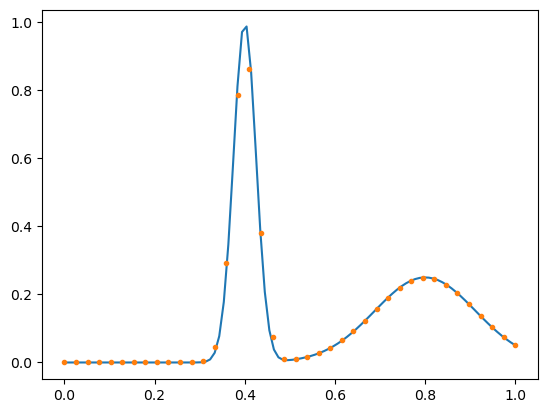

In [216]:
f = lambda x: (np.exp(-800*(x-0.4)**2)*((-1600*(x-0.4))**2-1601) + 0.25*np.exp(-40*(x-0.8)**2)*((-80*(x-0.8))**2-81))
c = u(0)
d = u(1)

N = 40
uhat = BVP1D(L=1, x=N, c=u(0), d=u(1), func=f, plot=None)

xax = np.linspace(0,1,100)
u = lambda x: np.exp(-800*(x-0.4)**2) + 0.25 * np.exp(-40*(x-0.8)**2)

plt.plot(xax, u(xax),label="Exact solution")
plt.plot(np.linspace(0,1,N), uhat, '.',label="FEM solution")

In [217]:
def convergence_test(h,L,c,d,u,func):
    x = np.linspace(0, L, int(L/h))
    uhat = BVP1D(L, x, c, d,func, plot=False)
    return np.linalg.norm(uhat-u(x),np.inf)

In [224]:
H = np.logspace(-1, -4, 10)
error = np.zeros(len(H))
for i,h in enumerate(H):
    error[i] = convergence_test(h,L,c,d,u,f)



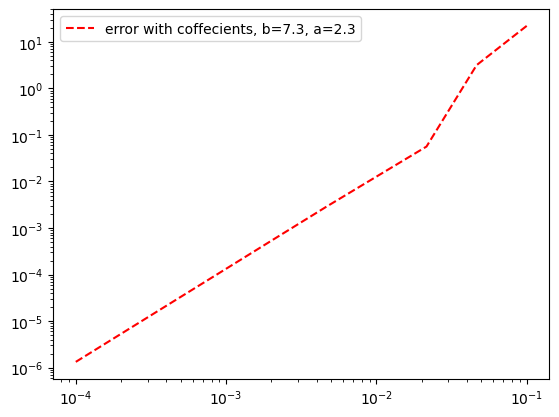

In [225]:
a,b = np.polyfit(np.log(H), np.log(error), 1)

plt.loglog(H, error, 'r--',label=f"error with coffecients, b={np.round(b,1)}, a={np.round(a,1)}")
plt.legend()
plt.show()


In [44]:
c = u(0)
d = u(1)
x = np.linspace(0,1,5)
u = lambda x: np.exp(-800*(x-0.4)**2) + 0.25 * np.exp(-40*(x-0.8)**2)

A, b = GlobalAssembly(c=c, d=d, func= u, x=x)
b

array([ 1.90546630e-12, -2.98833896e-04, -1.06198472e-02,  1.61793270e-01,
        5.04741295e-02])

*f)*

In [316]:
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

def refine_marked(EToVcoarse, xcoarse, idxMarked):
    N = len(EToVcoarse[:,0]) + 1
    Old2New = np.zeros((len(idxMarked),3),dtype=int)

    EToVfine = EToVcoarse.copy()
    xfine = xcoarse.copy()

    for i,idx in enumerate(idxMarked):

        xi   = xfine[EToVfine[idx][0]]
        xip1 = xfine[EToVfine[idx][1]]
        xih  =  xi + (xip1 - xi)/2

        xfine = np.hstack((xfine,[xih]))

        M = EToVfine[idx][1]
        EToVfine[idx][1] = N 
        EToVfine = np.vstack((EToVfine,[N,M]))

        Old2New[i] = [EToVfine[idx][0], N, M]

        N += 1

    return EToVfine, xfine, Old2New

K = lambda h: np.array([[1/h + h/3, -1/h + h/6], [-1/h + h/6, 1/h + h/3]])

def GlobalAssembly(x,c,d,func):
    M = len(x)
    nnzmax = 4 * M
    ii = np.ones(nnzmax, dtype=int)
    jj = np.ones(nnzmax, dtype=int)
    ss = np.zeros(nnzmax)
    b = np.zeros(M)
    count = 0

    for i in range(M - 1):
        h = x[i+1] - x[i]

        fval = func(x[i])

        if i > 0:
            b[i-1] += h*fval/6        
        b[i] += 2*h*fval/3
        b[i+1] += h*fval/6

        Ki = K(h)

        ii[count:count + 4] = [i, i, i + 1, i + 1]
        jj[count:count + 4] = [i, i + 1, i + 1, i]
        ss[count:count + 4] = [
        Ki[0, 0],
        Ki[0, 1],
        Ki[1, 1],
        Ki[1, 0]
        ]
        count += 4
    
    A = csr_matrix((ss[:count], (ii[:count], jj[:count])), shape=(M, M))
    b = -b
    
    # Boundary conditions
    b[0] = c
    b[1] -= A[0,1]*c

    A[0,0] = 1
    A[0,1] = 0
    A[1,0] = 0
    
    b[M-1] = d
    b[M-2] -= A[M-1,M-2]*d

    A[M-1,M-1] = 1
    A[M-1,M-2] = 0
    A[M-2,M-1] = 0

    

    return A, b

def BVP1D(L, x, c, d,func, plot=True):
    
    if type(x) == int:
        x = np.linspace(0, L, x)

    A,b = GlobalAssembly(x,c,d,func)

    u = sparse.linalg.spsolve(A, b)
    
    if plot:
        plt.plot(x, u, '.',label="FEM solution")
        plt.show()

    return u



def prep_grid(L,c,d,VXc,EToVc,func):
    idxMarked = np.arange(len(VXc)-1)

    # sorter her efter value
    sort_indices_c = np.argsort(VXc)
    uc = BVP1D(L, VXc[sort_indices_c], c, d,func, plot=False)



    EToVf, VXf,Old2New = refine_marked(EToVc,VXc,idxMarked)

    sort_indices_f = np.argsort(VXf)
    uf = BVP1D(L, VXf[sort_indices_f], c, d,func, plot=False)
    
    # sorter her efter index
    uc = uc[np.argsort(sort_indices_c)]
    uf = uf[np.argsort(sort_indices_f)]

    return uc,uf, VXc, VXf, EToVc, EToVf, Old2New



def compute_error_decrease(uc,uf,VXc,VXf,Old2New):
    
    N = len(VXc)-1
    err = np.zeros(N)

    for n, triple in enumerate(Old2New):

        i = triple[0]
        j = triple[2]
        k = triple[1]

        xi   = VXc[i]
        xj = VXc[j]
        xk  =  xi + (xj - xi)/2

        uci  = uc[i]
        ucj =  uc[j]

        ufi = uf[i]
        ufk = uf[k]
        ufj = uf[j]

        a  = (ucj - uci) / (xj - xi)
        a1 = (ufk - ufi) / (xk - xi)
        a2 = (ufj - ufk) / (xj - xk)

        b = uci - a * xi
        b1 = ufi - a1 * xi
        b2 = ufj - a2 * xj


        int1 = ((a-a1)**2/3) * (xk**3 - xi**3) + (b-b1)**2 * (xk - xi) + (a-a1)*(b-b1) * (xk**2 - xi**2)
        int2 = ((a-a2)**2/3) * (xj**3 - xk**3) + (b-b2)**2 * (xj - xk) + (a-a2)*(b-b2) * (xj**2 - xk**2)
        
        err[n] = np.sqrt(int1 + int2)

    return err

def DriverAMR17(L,c,d,VXc,func,tol, maxit):
    it = 0
    idxMarked = [1]
    
    idxs = np.arange(len(VXc))
    EToVc = np.vstack((idxs[:-1], idxs[1:])).T
    
    while len(idxMarked)>0 and it < maxit:
        
        uc,uf, VXc, VXf, EToVc, EToVf, Old2New = prep_grid(L,c,d,VXc,EToVc,f)

        err = compute_error_decrease(uc,uf,VXc,VXf,Old2New)
        
        # Change strategy here
        
        # Old
        #if 
        #idxMarked = np.where(err > tol)[0]
        
        #New
        m = np.max(err)
        if m > tol:
            idxMarked = np.where(err > 0.91*m)[0]
        else:
            idxMarked = []
    
        EToVc, VXc, Old2New = refine_marked(EToVc,VXc,idxMarked)

        it +=1

    VXc = np.sort(VXc)
    uc = BVP1D(L, VXc, c, d,func, plot=False)
    
    
    return VXc, uc, it,Old2New



#%%
u = lambda x: np.exp(-800*(x-0.4)**2) + 0.25 * np.exp(-40*(x-0.8)**2)
L = 1
c = u(0)
d = u(1)
VXc = np.linspace(0,1,4)
idxs = np.arange(len(VXc))
EToVc = np.vstack((idxs[:-1], idxs[1:])).T

#func = lambda x: 1*x
f = lambda x: (np.exp(-800*(x-0.4)**2)*((-1600*(x-0.4))**2-1601) + 0.25*np.exp(-40*(x-0.8)**2)*((-80*(x-0.8))**2-81))

In [333]:
VX, uhat, it,Old2New = DriverAMR17(L,c,d,VXc,f,tol=10**(-4), maxit=100)
print(f"Number of points: {len(VX)}")
print(it)

Number of points: 165
49


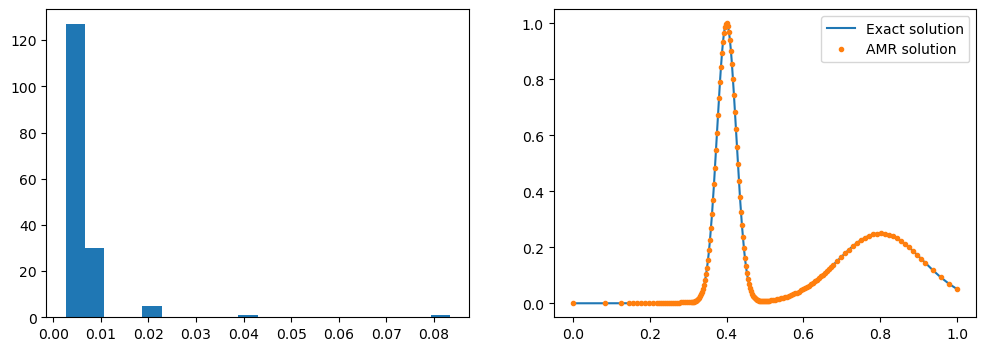

In [238]:
VX = np.sort(VX)

VXdiff = np.diff(VX) 

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].hist(VXdiff, bins=20)
ax[1].plot(VX, u(VX),label="Exact solution")
ax[1].plot(VX,uhat,".",label='AMR solution')
ax[1].legend()
plt.show()

0.06233152412947143
0.046819949024015
0.08264895402605218
0.08264895402605218
0.020222734812864268
0.006869937959593647
0.004545728361688706
0.002198804111102061
0.00032814906479240735
0.0002971053123563827


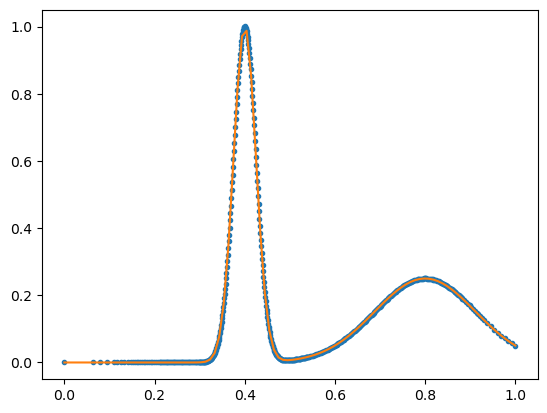

0.0002971053123563827
0
1
2
3
4
5
6
7
8
9


In [362]:
import time
TOL = np.logspace(-1, -5, 10)
M = list(range(10,500,10))
error_AMR = np.zeros(len(TOL))
error_FEM = np.zeros(len(TOL))
Npoints = np.zeros(len(TOL))
CPUtime_AMR = np.zeros(len(TOL))
CPUtime_FEM = np.zeros(len(TOL))

x = np.linspace(0,1,3)
N = 5
for i,tol in enumerate(TOL):
    start_time = time.process_time()
    VX, uhat, it,Old2New = DriverAMR17(L,c,d,x,f,tol, maxit=100)
    end_time = time.process_time()
    
    error_AMR[i] = np.linalg.norm(uhat-u(VX),np.inf)
    Npoints[i] = len(VX)
    CPUtime_AMR[i] += end_time - start_time

for i,n in enumerate(Npoints):
    x = np.linspace(0,1,int(n))
    print(i)
    start_time = time.process_time()
    uhat = BVP1D(L, x, c, d,f, plot=False)
    end_time = time.process_time()
    error_FEM[i] = np.linalg.norm(uhat-u(x),np.inf)
    CPUtime_FEM[i] += end_time - start_time


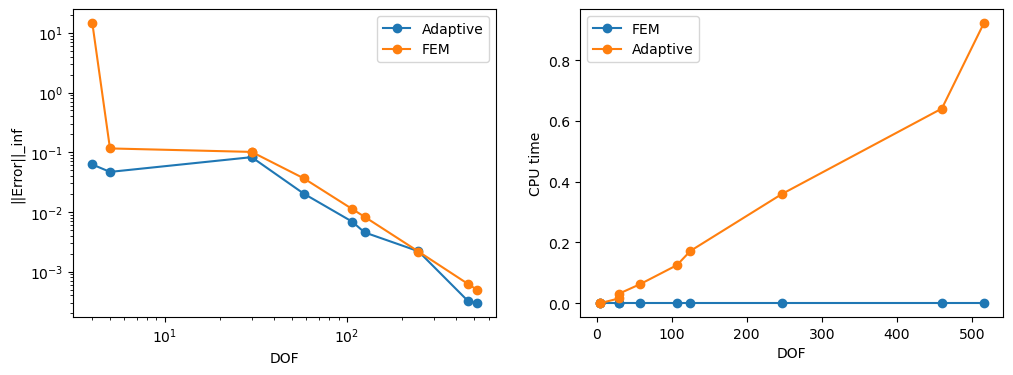

In [363]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].loglog(Npoints, error_AMR,"o-",label="Adaptive")
ax[0].loglog(Npoints, error_FEM,"o-",label="FEM")
ax[0].set_xlabel("DOF")
ax[0].set_ylabel("||Error||_inf")
ax[0].legend()

ax[1].plot(Npoints, CPUtime_FEM,"o-",label="FEM")
ax[1].plot(Npoints, CPUtime_AMR,"o-",label="Adaptive")
ax[1].set_xlabel("DOF")
ax[1].set_ylabel("CPU time")
ax[1].legend()

plt.show()


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])